In [28]:
# dependencies
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score
from pymongo import MongoClient
import seaborn as sns

my_dir = os.path.dirname(os.path.abspath('__file__'))
os.chdir(my_dir)

from sklearn.datasets import make_regression
from sklearn.linear_model import RidgeCV

In [2]:
# add the case shiller price index to the data in order to incorporate national price trends
connection = MongoClient('mongodb://localhost:27017')
db = connection['housing']

collection = db['ames_ia']
cursor = collection.find({})
data = list(cursor)

collection_shiller = db['case_shiller']
cursor = collection_shiller.find({})
shiller_data = list(cursor)

ames_df = pd.DataFrame(data)
cs_df = pd.DataFrame(shiller_data)

connection.close()

In [3]:
print(ames_df.columns)


Index(['_id', 'Lot Area', 'Neighborhood', 'Bldg Type', 'House Style',
       'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add',
       'Bsmt Unf SF', 'Heating', 'Central Air', '1st Flr SF', '2nd Flr SF',
       'Gr Liv Area', 'Bedroom AbvGr', 'Kitchen Qual', 'TotRms AbvGrd',
       'Garage Type', 'Garage Cars', 'Garage Area', 'Wood Deck SF',
       'Open Porch SF', 'Enclosed Porch', 'Screen Porch', 'Mo Sold', 'Yr Sold',
       'SalePrice', 'Total Bathrooms', 'Remodeled Y/N', 'Total BsmtFin SF',
       'FinBsmt/Gr Liv Area'],
      dtype='object')


In [4]:
ames_df = ames_df.merge(cs_df, left_on = 'Yr Sold', right_on = 'Year', how = 'left')
ames_df.drop(columns = ['Year'], inplace = True)

In [5]:
categorical_columns = ames_df.select_dtypes(include=['object']).columns.tolist()
print(categorical_columns)


['_id_x', 'Neighborhood', 'Bldg Type', 'House Style', 'Heating', 'Central Air', 'Kitchen Qual', 'Garage Type', 'Remodeled Y/N', '_id_y']


In [6]:
#ames_df.rename(columns={'Total Bathrooms': 'Bath'}, inplace=True)
ames_df.rename(columns={'Bedroom AbvGr': 'bedrooms',
'TotRms AbvGrd': 'total_rooms', 'Gr Liv Area': 'total_sqr_ft',
'Garage Cars': 'car_garage', 'Year Built': 'year_built',}, inplace=True)



In [7]:
ames_df['House Style'].unique()

array(['1Story', '2Story', '1.5Fin', 'SFoyer', 'SLvl', '2.5Unf', '1.5Unf',
       '2.5Fin'], dtype=object)

In [8]:
# Create a mapping dictionary
style_mapping = {
    '1Story': 'Single Story',
    '2Story': 'Two Story',
    '1.5Fin': 'Finished 1 1/2 Story',
    'SFoyer': 'Split Foyer Style',
    'SLvl': 'Split Level Style',
    '2.5Unf': 'Unfinished 2 1/2 Story',
    '1.5Unf': 'Unfinished 1 1/2 Story',
    '2.5Fin': 'Finished 2 1/2 Story'
}

# Map the values in the 'House Style' column using the mapping dictionary
ames_df['House Style'] = ames_df['House Style'].map(style_mapping)


In [9]:
ames_df['House Style'].unique()

array(['Single Story', 'Two Story', 'Finished 1 1/2 Story',
       'Split Foyer Style', 'Split Level Style', 'Unfinished 2 1/2 Story',
       'Unfinished 1 1/2 Story', 'Finished 2 1/2 Story'], dtype=object)

In [10]:
print(ames_df['Neighborhood'].unique())

['NAmes' 'Gilbert' 'StoneBr' 'NWAmes' 'Somerst' 'BrDale' 'NPkVill'
 'NridgHt' 'Blmngtn' 'NoRidge' 'SawyerW' 'Sawyer' 'Greens' 'BrkSide'
 'OldTown' 'ClearCr' 'SWISU' 'Edwards' 'IDOTRR' 'CollgCr' 'Mitchel'
 'MeadowV' 'Crawfor' 'Blueste' 'Timber' 'Veenker' 'GrnHill' 'Landmrk']


In [11]:
numerical_features = ames_df.select_dtypes(include=[np.number]).columns.tolist()
for feature in numerical_features:
    ames_df[feature].fillna(ames_df[feature].median(), inplace=True)

In [12]:
categorical_features = ames_df.select_dtypes(include=[np.object]).columns.tolist()
for feature in categorical_features:
    ames_df[feature].fillna('None', inplace=True)

C:\Users\sarah\AppData\Local\Temp\ipykernel_41980\1298506737.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categorical_features = ames_df.select_dtypes(include=[np.object]).columns.tolist()


In [13]:
X = ames_df.drop(['_id_x', '_id_y', 'SalePrice'], axis=1)  # All columns except target variable
y = ames_df['SalePrice']  # Target variable

In [14]:
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
print(categorical_columns)


['Neighborhood', 'Bldg Type', 'House Style', 'Heating', 'Central Air', 'Kitchen Qual', 'Garage Type', 'Remodeled Y/N']


In [15]:
X.columns = X.columns.str.lower()


In [16]:
X.columns

Index(['lot area', 'neighborhood', 'bldg type', 'house style', 'overall qual',
       'overall cond', 'year_built', 'year remod/add', 'bsmt unf sf',
       'heating', 'central air', '1st flr sf', '2nd flr sf', 'total_sqr_ft',
       'bedrooms', 'kitchen qual', 'total_rooms', 'garage type', 'car_garage',
       'garage area', 'wood deck sf', 'open porch sf', 'enclosed porch',
       'screen porch', 'mo sold', 'yr sold', 'total bathrooms',
       'remodeled y/n', 'total bsmtfin sf', 'finbsmt/gr liv area',
       'avg cs index value'],
      dtype='object')

In [17]:
# Your list of original column names
original_columns = ['lot area', 'neighborhood', 'bldg type', 'house style', 'overall qual',
       'overall cond', 'year_built', 'year remod/add', 'bsmt unf sf',
       'heating', 'central air', '1st flr sf', '2nd flr sf', 'total_sqr_ft',
       'bedrooms', 'kitchen qual', 'total_rooms', 'garage type', 'car_garage',
       'garage area', 'wood deck sf', 'open porch sf', 'enclosed porch',
       'screen porch', 'mo sold', 'yr sold', 'total bathrooms',
       'remodeled y/n', 'total bsmtfin sf', 'finbsmt/gr liv area',
       'avg cs index value']

# Replace spaces with underscores in column names
modified_columns = [col.replace(' ', '_') for col in original_columns]

# Rename columns in DataFrame X
X.columns = modified_columns

In [18]:
X.columns

Index(['lot_area', 'neighborhood', 'bldg_type', 'house_style', 'overall_qual',
       'overall_cond', 'year_built', 'year_remod/add', 'bsmt_unf_sf',
       'heating', 'central_air', '1st_flr_sf', '2nd_flr_sf', 'total_sqr_ft',
       'bedrooms', 'kitchen_qual', 'total_rooms', 'garage_type', 'car_garage',
       'garage_area', 'wood_deck_sf', 'open_porch_sf', 'enclosed_porch',
       'screen_porch', 'mo_sold', 'yr_sold', 'total_bathrooms',
       'remodeled_y/n', 'total_bsmtfin_sf', 'finbsmt/gr_liv_area',
       'avg_cs_index_value'],
      dtype='object')

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =42)


In [27]:
X_train.columns

Index(['lot_area', 'neighborhood', 'bldg_type', 'house_style', 'overall_qual',
       'overall_cond', 'year_built', 'year_remod/add', 'bsmt_unf_sf',
       'heating', 'central_air', '1st_flr_sf', '2nd_flr_sf', 'total_sqr_ft',
       'bedrooms', 'kitchen_qual', 'total_rooms', 'garage_type', 'car_garage',
       'garage_area', 'wood_deck_sf', 'open_porch_sf', 'enclosed_porch',
       'screen_porch', 'mo_sold', 'yr_sold', 'total_bathrooms',
       'remodeled_y/n', 'total_bsmtfin_sf', 'finbsmt/gr_liv_area',
       'avg_cs_index_value'],
      dtype='object')

In [20]:
# Categorical regressor  

from catboost import CatBoostRegressor

categorical_columns = list(X.loc[:, X.dtypes == 'object'].columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =42)

model = CatBoostRegressor(iterations = 500, depth = 6, cat_features = categorical_columns, random_seed = 42, verbose = 3)

param_grid = {
    'iterations': [100, 300, 500],            
    'learning_rate': [0.01, 0.1],        
    'depth': [6, 8],                       
}

grid_search = GridSearchCV(model, param_grid, cv=5, verbose=3, scoring = 'neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(best_params)

best_model = CatBoostRegressor(cat_features = categorical_columns, random_seed = 42, verbose = 3, **best_params)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print(f"{mean_squared_error(y_test, y_pred):.2f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
0:	learn: 77463.2375483	total: 251ms	remaining: 24.9s
3:	learn: 75918.7737365	total: 526ms	remaining: 12.6s
6:	learn: 74403.6326797	total: 852ms	remaining: 11.3s
9:	learn: 72919.4786524	total: 1.17s	remaining: 10.5s
12:	learn: 71558.7214093	total: 1.5s	remaining: 10s
15:	learn: 70189.5733963	total: 1.85s	remaining: 9.72s
18:	learn: 68839.1843591	total: 2.17s	remaining: 9.27s
21:	learn: 67515.5607906	total: 2.5s	remaining: 8.86s
24:	learn: 66258.2450157	total: 2.81s	remaining: 8.43s
27:	learn: 64962.4974850	total: 3.13s	remaining: 8.06s
30:	learn: 63737.6981206	total: 3.47s	remaining: 7.72s
33:	learn: 62581.0726607	total: 3.79s	remaining: 7.36s
36:	learn: 61453.7011807	total: 4.43s	remaining: 7.55s
39:	learn: 60324.4601502	total: 4.78s	remaining: 7.17s
42:	learn: 59247.2021028	total: 5.64s	remaining: 7.48s
45:	learn: 58204.6014774	total: 5.97s	remaining: 7s
48:	learn: 57149.1046511	total: 6.28s	remaining: 6.54s
51:	learn: 5614

In [21]:
print(f"Training R-squared: {best_model.score(X_train, y_train)}")
print(f"Test R-squared: {best_model.score(X_test, y_test)}")

Training R-squared: 0.9861259639868052
Test R-squared: 0.9294257040671728


In [22]:
X_train.to_csv('data/training_data.csv', index=False)

In [23]:
import pickle

with open('best_model_catBoost.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

In [25]:
print("Length of y_pred:", len(y_pred))
print("Length of y_test:", len(y_test))

pred_values = {"y_pred": y_pred,
"y_test": y_test}
pred_dataframe = pd.DataFrame(pred_values)

Length of y_pred: 586
Length of y_test: 586


In [26]:
# predictive visual 
fig2 = px.scatter(pred_dataframe, x='y_pred', y='y_test', title='Predicted vs Actual Y Values')
fig2.show()

#fit a line on top

<Axes: ylabel='SalePrice'>

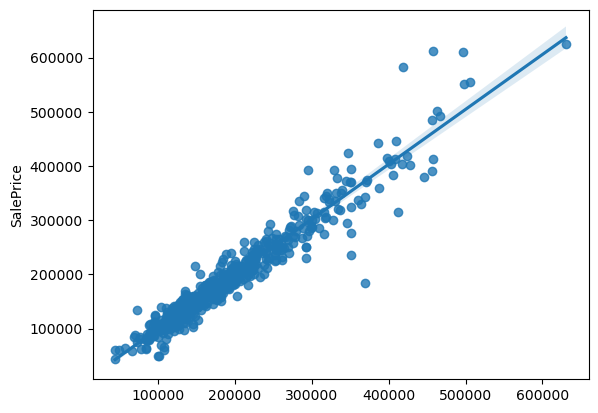

In [30]:
sns.regplot(x="y_pred", y="y_test", data=pred_values)